In [1]:
class_names = ['motobike']

num_classes = len(class_names)

from os import path

from collections.abc import Iterable

from utils import tools

In [2]:
class Yolo_data(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.file_names = None
        
    def read_file_to_dataset(
        self, img_path=None, label_path=None,
        label_format="labelimg",
        rescale=1/255,
        preprocessing=None,
        augmenter=None,
        aug_times=1,
        shuffle=True, seed=None,
        encoding="big5",
        thread_num=10):
        
        grid_amp = 2**(self.fpn_layers - 1)
        grid_shape = (self.grid_shape[0]*grid_amp,
                      self.grid_shape[1]*grid_amp)
        img_data, label_data, path_list = tools.read_file(
            img_path=img_path, 
            label_path=label_path,
            label_format=label_format,
            size=self.input_shape[:2], 
            grid_shape=grid_shape,
            class_names=self.class_names,
            rescale=rescale,
            preprocessing=preprocessing,
            augmenter=augmenter,
            aug_times=aug_times,
            shuffle=shuffle, seed=seed,
            encoding=encoding,
            thread_num=thread_num)
        self.file_names = path_list

        label_list = [label_data]
        for _ in range(self.fpn_layers - 1):
            label_data = tools.down2xlabel(label_data)
            label_list.insert(0, label_data)

        return img_data, label_list

    def vis_img(self, img, *label_datas,
                conf_threshold=0.5,
                show_conf=True,
                nms_mode=0,
                nms_threshold=0.5,
                nms_sigma=0.5,
                **kwargs):

        return tools.vis_img(
                             img, 
                             *label_datas, 
                             class_names=self.class_names,
                             conf_threshold=conf_threshold,
                             show_conf=show_conf,
                             nms_mode=nms_mode,  
                             nms_threshold=nms_threshold,
                             nms_sigma=nms_sigma,
                             version=3,
                             **kwargs)

In [3]:
yolo_data = Yolo_data(class_names=class_names)

In [4]:
# yolo_data = Yolo_data(class_names=class_names)
# img_path   = "../Mydata/TrainImage/"
# label_path = "../Mydata/XMLTrainImage/"

# train_img, train_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     label_format="labelimg",
#     thread_num=1,
#     shuffle=False)

In [5]:
# img_path   = "../Mydata/ValImage/"
# label_path = "../Mydata/XMLValImage/"

# val_img, val_label = yolo_data.read_file_to_dataset(
#     img_path, label_path,
#     label_format="labelimg",
#     thread_num=1,
#     shuffle=False)

In [6]:
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, ZeroPadding2D, LeakyReLU, BatchNormalization, concatenate
from keras.initializers import RandomNormal
from keras.regularizers import l2
import tensorflow as tf
import numpy as np

n_epoch = 10
epsilon = 1e-07

In [7]:
from functools import wraps
from functools import reduce
@wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    '''Wrapper to set Darknet parameters for Convolution2D.'''
    darknet_conv_kwargs = {'kernel_initializer': 'he_normal'}
    if kwargs.get('strides') == (2, 2):
        darknet_conv_kwargs['padding'] = 'valid'
    else:
        darknet_conv_kwargs['padding'] = 'same'
    darknet_conv_kwargs.update(kwargs)
    return Conv2D(*args, **darknet_conv_kwargs)


In [8]:
'''
05. Mish Activation
'''
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [9]:
## Residual Block

def DarknetConv2D_BN_Leaky(input_layer, filters_shape, downsample=False, activate=True, bn=True, activate_type='leaky'):
    if downsample:
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid'
        strides = 2
    else:
        strides = 1
        padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        if activate_type == "leaky":
            conv = LeakyReLU(alpha=0.1)(conv)
        elif activate_type == "mish":
            conv = mish(conv)

    return conv

In [10]:
def DarknetResidual(input_layer, input_channel, filter_num1, filter_num2, activate_type='leaky'):
    short_cut = input_layer
    conv = DarknetConv2D_BN_Leaky(input_layer, filters_shape=(1, 1, input_channel, filter_num1), activate_type=activate_type)
    conv = DarknetConv2D_BN_Leaky(conv       , filters_shape=(3, 3, filter_num1,   filter_num2), activate_type=activate_type)

    residual_output = short_cut + conv
    return residual_output

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')


In [11]:
### Backbone darknet
def Backbone_darknet(input_tensor):
    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3,  3,  32))
    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3, 32,  64), downsample=True)

    for i in range(1):
        input_tensor = DarknetResidual(input_tensor,  64,  32, 64)

    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3,  64, 128), downsample=True)

    for i in range(2):
        input_tensor = DarknetResidual(input_tensor, 128,  64, 128)

    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3, 128, 256), downsample=True)

    for i in range(8):
        input_tensor = DarknetResidual(input_tensor, 256, 128, 256)

    route_1 = input_tensor
    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3, 256, 512), downsample=True)

    for i in range(8):
        input_tensor = DarknetResidual(input_tensor, 512, 256, 512)

    route_2 = input_tensor
    input_tensor = DarknetConv2D_BN_Leaky(input_tensor, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
        input_tensor = DarknetResidual(input_tensor, 1024, 512, 1024)

    return route_1, route_2, input_tensor


In [12]:
WEIGHTS_PATH_DN_BODY    = "https://github.com/samson6460/tf2_YOLO/releases/download/1.0/tf_keras_yolov3_body.h5"
WEIGHTS_PATH_DN53_TOP   = "https://github.com/samson6460/tf2_YOLO/releases/download/Weights/tf_keras_darknet53_448_include_top.h5"
WEIGHTS_PATH_DN53_NOTOP = "https://github.com/samson6460/tf2_YOLO/releases/download/Weights/tf_keras_darknet53_448_no_top.h5"


In [13]:
#### YOLO Neck
def yolo_neck(input_shape=(416, 416, 3),
              pretrained_darknet=None,
              pretrained_weights=None):
    '''Create YOLO_V3 model CNN body in Keras.'''
    input_tensor = Input(input_shape)
    route_1, route_2, conv = Backbone_darknet(input_tensor)
    # if pretrained_darknet is not None:
    #     darknet.set_weights(pretrained_darknet.get_weights())
    
    # conv, conv_lobj_branch = make_last_layers(conv, 512)
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 1024,  512))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3,  512, 1024))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 1024,  512))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3,  512, 1024))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 1024,  512))
    conv_lobj_branch = DarknetConv2D_BN_Leaky(conv, (3, 3, 512, 1024))
    
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 256, 128))
    conv = upsample(conv)
    
    conv = tf.concat([conv, route_2], axis=-1)
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 768, 256))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3, 256, 512))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 512, 256))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3, 256, 512))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 512, 256))
    conv_mobj_branch = DarknetConv2D_BN_Leaky(conv, (3, 3, 256, 512))

    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 384, 128))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3, 128, 256))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 256, 128))
    conv = DarknetConv2D_BN_Leaky(conv, (3, 3, 128, 256))
    conv = DarknetConv2D_BN_Leaky(conv, (1, 1, 256, 128))
    conv_sobj_branch = DarknetConv2D_BN_Leaky(conv, (3, 3, 128, 256))
    
    model = Model(input_tensor, [conv_lobj_branch, conv_mobj_branch, conv_sobj_branch])

    return model

In [14]:
def yolo_head(model_body, class_num=10, 
              anchors=[[0.89663461, 0.78365384],
                       [0.37500000, 0.47596153],
                       [0.27884615, 0.21634615],
                       [0.14182692, 0.28605769],
                       [0.14903846, 0.10817307],
                       [0.07211538, 0.14663461],
                       [0.07932692, 0.05528846],
                       [0.03846153, 0.07211538],
                       [0.02403846, 0.03125000]]):
    anchors = np.array(anchors)
    inputs = model_body.input
    output = model_body.output
    tensor_num = len(output)

    if len(anchors)%tensor_num > 0:
        raise ValueError(("The total number of anchor boxs"
                          " should be a multiple of the number(%s)"
                          " of output tensors") % tensor_num)    
    abox_num = len(anchors)//tensor_num

    outputs_list = []
    for tensor_i, output_tensor in enumerate(output):
        output_list = []
        start_i = tensor_i*abox_num
        for box in anchors[start_i:start_i + abox_num]:
            xy_output = DarknetConv2D(2, 1,
                            activation='sigmoid')(output_tensor)
            wh_output = DarknetConv2D(2, 1,
                            activation='exponential')(output_tensor)
            wh_output = wh_output * box
            c_output = DarknetConv2D(1, 1,
                            activation='sigmoid')(output_tensor)
            p_output = DarknetConv2D(class_num, 1,
                            activation='sigmoid')(output_tensor)
            output_list += [xy_output,
                            wh_output,
                            c_output,
                            p_output]

        outputs = concatenate(output_list, axis=-1)
        outputs_list.append(outputs)
    
    model = Model(inputs, outputs_list)    

    return model

In [15]:
def cal_iou(xywh_true, xywh_pred, grid_shape):
    grid_shape = np.array(grid_shape[::-1])
    xy_true = xywh_true[..., 0:2]/grid_shape # N*S*S*1*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2]/grid_shape # N*S*S*B*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = tf.maximum(mins_pred,  mins_true)
    intersect_maxes = tf.minimum(maxes_pred, maxes_true)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = (intersect_areas + epsilon)/(union_areas + epsilon)
    
    return iou_scores

In [16]:
def wrap_yolo_loss(grid_shape,
                   bbox_num,
                   class_num,
                   anchors,
                   binary_weight=1,
                   loss_weight=[1, 1, 1, 1],
                   ignore_thresh=.6,
                   ):
    def yolo_loss(y_true, y_pred):
        panchors = tf.reshape(anchors, (1, 1, 1, bbox_num, 2))

        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*(5+C)
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*(5+C)

        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        
        response_mask = tf.one_hot(tf.argmax(iou_scores, axis=-1),
                                   depth=bbox_num,
                                   dtype=xywh_true.dtype) # N*S*S*B

        has_obj_mask = y_true[..., 4]*response_mask # N*S*S*B
        has_obj_mask_exp = tf.expand_dims(has_obj_mask, axis=-1) # N*S*S*B*1

        no_obj_mask = tf.cast(
            iou_scores < ignore_thresh,
            iou_scores.dtype) # N*S*S*B
        no_obj_mask = (1 - has_obj_mask)*no_obj_mask # N*S*S*B

        xy_true = y_true[..., 0:2] # N*S*S*1*2
        xy_pred = y_pred[..., 0:2] # N*S*S*B*2

        wh_true = tf.maximum(y_true[..., 2:4]/panchors, epsilon) # N*S*S*1*2
        wh_pred = y_pred[..., 2:4]/panchors
        
        wh_true = tf.math.log(wh_true) # N*S*S*B*2
        wh_pred = tf.math.log(wh_pred) # N*S*S*B*2

        c_pred = y_pred[..., 4] # N*S*S*B

        box_loss_scale = 2 - y_true[..., 2:3]*y_true[..., 3:4] # N*S*S*1*1

        xy_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(xy_true - xy_pred), # N*S*S*B*2
                axis=0))

        wh_loss = tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *box_loss_scale # N*S*S*1*1
                *tf.square(wh_true - wh_pred), # N*S*S*B*2
                axis=0))

        has_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                has_obj_mask # N*S*S*1
                *(tf.square(1 - c_pred)), # N*S*S*B
                axis=0))

        no_obj_c_loss = tf.reduce_sum(
                tf.reduce_mean(
                no_obj_mask # N*S*S*1
                *(tf.square(0 - c_pred)), # N*S*S*B
                axis=0))
        
        c_loss = has_obj_c_loss + binary_weight*no_obj_c_loss

        p_true = y_true[..., -class_num:] # N*S*S*1*C
        p_pred = y_pred[..., -class_num:] # N*S*S*B*C
        p_pred = tf.clip_by_value(p_pred, epsilon, 1 - epsilon)
        p_loss = -tf.reduce_sum(
            tf.reduce_mean(
                has_obj_mask_exp # N*S*S*B*1
                *(p_true*tf.math.log(p_pred)
                + (1 - p_true)*tf.math.log(1 - p_pred)), # N*S*S*B*C
                axis=0))
        
        regularizer = tf.reduce_sum(
            tf.reduce_mean(wh_pred**2, axis=0))*0.01

        loss = (loss_weight[0]*xy_loss
                + loss_weight[1]*wh_loss
                + loss_weight[2]*c_loss
                + loss_weight[3]*p_loss
                + regularizer)

        return loss

    return yolo_loss

In [17]:
from keras.metrics import binary_accuracy

epsilon = 1e-07

def wrap_obj_acc(grid_shape, bbox_num, class_num):
    def obj_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C
        
        c_true = y_true[..., 4] # N*S*S*1
        c_pred = tf.reduce_max(y_pred[..., 4], # N*S*S*B
                               axis=-1,
                               keepdims=True) # N*S*S*1

        bi_acc = binary_accuracy(c_true, c_pred)

        return bi_acc
    return obj_acc

In [18]:
def wrap_mean_iou(grid_shape, bbox_num, class_num):
    def mean_iou(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1
        
        xywh_true = y_true[..., :4] # N*S*S*1*4
        xywh_pred = y_pred[..., :4] # N*S*S*B*4

        iou_scores = cal_iou(xywh_true, xywh_pred, grid_shape) # N*S*S*B
        iou_scores = tf.reduce_max(iou_scores, axis=-1, keepdims=True) # N*S*S*1
        iou_scores = iou_scores*has_obj_mask # N*S*S*1

        num_p = tf.reduce_sum(has_obj_mask)

        return tf.reduce_sum(iou_scores)/(num_p + epsilon)
    return mean_iou

In [19]:
def wrap_class_acc(grid_shape, bbox_num, class_num):
    def class_acc(y_true, y_pred):
        y_true = tf.reshape(
            y_true,
            (-1, *grid_shape, 1, 5 + class_num)) # N*S*S*1*5+C
        y_pred = tf.reshape(
            y_pred,
            (-1, *grid_shape, bbox_num, 5 + class_num)) # N*S*S*B*5+C

        has_obj_mask = y_true[..., 4] # N*S*S*1

        pi_true = tf.argmax(y_true[..., -class_num:], # N*S*S*1*C
                            axis=-1) # N*S*S*1
        pi_pred = tf.argmax(y_pred[..., -class_num:], # N*S*S*B*C
                            axis=-1) # N*S*S*B
        
        equal_mask = tf.cast(pi_true == pi_pred,
                             dtype=y_true.dtype) # N*S*S*B
        equal_mask = equal_mask*has_obj_mask # N*S*S*B

        num_p = tf.reduce_sum(has_obj_mask)*bbox_num

        return tf.reduce_sum(equal_mask)/(num_p + epsilon)
    return class_acc


In [20]:
class Yolo(object):

    def __init__(self,
                 input_shape=(416, 416, 3),
                 class_names=[]):
        self.input_shape = input_shape
        self.grid_shape = input_shape[0]//32, input_shape[1]//32
        self.abox_num = 3
        self.class_names = class_names
        self.class_num = len(class_names)
        self.fpn_layers = 3
        self.anchors = None
        self.model = None
        self.file_names = None
        
    '''
    18. Model Create
    '''
    def create_model(self,
                     anchors=[[0.89663461, 0.78365384],
                              [0.37500000, 0.47596153],
                              [0.27884615, 0.21634615],
                              [0.14182692, 0.28605769],
                              [0.14903846, 0.10817307],
                              [0.07211538, 0.14663461],
                              [0.07932692, 0.05528846],
                              [0.03846153, 0.07211538],
                              [0.02403846, 0.03125000]],
                     backbone="full_darknet",
                     pretrained_weights=None,
                     pretrained_darknet="pascal_voc"):
        
        if isinstance(pretrained_darknet, str):
            pre_body_weights = pretrained_darknet
            pretrained_darknet = None
        else:
            pre_body_weights = None
        
        model_body = yolo_neck(self.input_shape,
            pretrained_weights=pre_body_weights)

        if pretrained_darknet is not None:
            model_body.set_weights(pretrained_darknet.get_weights())
        self.model = yolo_head(model_body,
                               self.class_num,
                               anchors)
         
        if pretrained_weights is not None:
            self.model.load_weights(pretrained_weights)
        self.anchors = anchors
        self.grid_shape = self.model.output[0].shape[1:3]
        self.fpn_layers = len(self.model.output)
        self.abox_num = len(self.anchors)//self.fpn_layers

    '''
    19. Loss Create
    '''
    def loss(self,
             binary_weight=1,
             loss_weight=[1, 1, 5, 1],
             ignore_thresh=0.6):

        if (not isinstance(binary_weight, Iterable)
            or len(binary_weight) != self.fpn_layers):
            binary_weight = [binary_weight]*self.fpn_layers
        
        if isinstance(loss_weight, dict):
            loss_weight_list = []
            loss_weight_list.append(loss_weight["xy"])
            loss_weight_list.append(loss_weight["wh"])
            loss_weight_list.append(loss_weight["conf"])
            loss_weight_list.append(loss_weight["prob"])
            loss_weight = loss_weight_list
        
        loss_list = []
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                          self.grid_shape[1]*grid_amp)
            anchors_id = self.abox_num*fpn_id
            loss_list.append(wrap_yolo_loss(
                grid_shape=grid_shape,
                bbox_num=self.abox_num, 
                class_num=self.class_num,
                anchors=self.anchors[
                    anchors_id:anchors_id + self.abox_num],
                binary_weight=binary_weight[fpn_id],
                loss_weight=loss_weight,
                ignore_thresh=ignore_thresh))
        return loss_list
    
    '''
    20. Metrics Create
    '''
    def metrics(self, type="obj_acc"):
        
        metrics_list = [[] for _ in range(self.fpn_layers)]
        for fpn_id in range(self.fpn_layers):
            grid_amp = 2**(fpn_id)
            grid_shape = (self.grid_shape[0]*grid_amp,
                            self.grid_shape[1]*grid_amp)
            
            if "obj" in type:
                metrics_list[fpn_id].append(
                    wrap_obj_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "iou" in type:
                metrics_list[fpn_id].append(
                    wrap_mean_iou(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
            if "class" in type:
                metrics_list[fpn_id].append(
                    wrap_class_acc(
                        grid_shape,
                        self.abox_num, 
                        self.class_num))
        
        return metrics_list

In [21]:
yolo = Yolo(class_names=class_names)

In [22]:
# from utils.kmeans import kmeans, iou_dist, euclidean_dist
# import numpy as np

# all_boxes = train_label[2][train_label[2][..., 4] == 1][..., 2:4]
# anchors = kmeans(
#     all_boxes,
#     n_cluster=9,
#     dist_func=iou_dist,
#     stop_dist=0.000001)

# anchors = np.sort(anchors, axis=0)[::-1]
# display(anchors)

In [23]:
# anchors=[[0.18779223, 0.26137096],
#        [0.17727496, 0.24374145],
#        [0.16971926, 0.2308511 ],
#        [0.16248433, 0.21979941],
#        [0.1547918 , 0.20906165],
#        [0.14827792, 0.19636963],
#        [0.13722295, 0.18287213],
#        [0.12978053, 0.17237878],
#        [0.12378935, 0.16336633]]
anchors=[[0.17974663, 0.24750794],
       [0.16224557, 0.21994163],
       [0.13819972, 0.18308146]]

yolo.create_model(anchors=anchors)
yolo.model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 416, 416, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['batch_normalization[

In [24]:
# from keras.optimizers import Adam
# from keras.callbacks import LearningRateScheduler
# optimizer = Adam(learning_rate=5e-5)

# def scheduler(epoch, lr):
#     if epoch <= 20:
#         return lr
#     elif epoch <= 70:
#         return 3e-5
#     else:
#         return 1e-5

# callback = LearningRateScheduler(scheduler)



# from keras.optimizers import Adam
# optimizer = Adam(learning_rate=1e-4)
# from keras.callbacks import EarlyStopping
# callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

In [25]:
# from utils.tools import get_class_weight

# binary_weight_list = []

# for i in range(len(train_label)):
#     binary_weight_list.append(
#         get_class_weight(
#         train_label[i][..., 4:5],
#         method='binary'
#         )
#     )
# print(binary_weight_list)

# binary_weight_list = [0.1]*3


# ignore_thresh = 0.7
# use_focal_loss = True

# loss_weight = {
#     "xy":1,
#     "wh":1,
#     "conf":5,
#     "prob":1
#     }

# loss_fn = yolo.loss(
#     binary_weight_list,
#     loss_weight=loss_weight,
#     ignore_thresh=ignore_thresh
#     )

In [26]:
# metrics = yolo.metrics("obj+iou+class")

In [27]:
# yolo.model.compile(
#     optimizer = optimizer,
#     #optimizer=SGD(learning_rate=1e-10, momentum=0.9, decay=5e-4),
#     loss = loss_fn,
#     metrics = metrics
#     )

In [28]:
# train_history = yolo.model.fit(
#     train_img,
#     train_label,
#     epochs = n_epoch,
#     batch_size=5,
#     verbose=1,
#     validation_data=(val_img, val_label),
#     callbacks=[callback]
#     )

In [29]:
yolo.model.load_weights("./yolov3_3_anchor.h5")

In [30]:
def decode(*label_datas,
           class_num=1,
           threshold=0.5,
           version=1):
    """Decode the prediction from yolo model.

    Args:
        *label_datas: Ndarrays,
            shape: (grid_heights, grid_widths, info).
            Multiple label data can be given at once.
        class_num:  An integer,
            number of classes.
        threshold: A float,
            threshold for quantizing output.
        version: An integer,
            specifying the decode method, yolov1、v2 or v3.

    Return:
        Numpy.ndarray with shape: (N, 7).
            7 values represent:
            x, y, w, h, c, class index, class probability.
    """
    output = []
    for label_data in label_datas:
        grid_shape = label_data.shape[:2]
        if version == 1:
            bbox_num = (label_data.shape[-1] - class_num)//5
            xywhc = np.reshape(label_data[..., :-class_num],
                               (*grid_shape, bbox_num, 5))
            prob = np.expand_dims(
                label_data[..., -class_num:], axis=-2)
        elif version == 2 or version == 3:
            bbox_num = label_data.shape[-1]//(5 + class_num)
            label_data = np.reshape(label_data,
                                    (*grid_shape,
                                     bbox_num, 5 + class_num))
            xywhc = label_data[..., :5]
            prob = label_data[..., -class_num:]
        else:
            raise ValueError("Invalid version: %s" % version)   

        # joint_conf = xywhc[..., 4:5]*prob
        joint_conf = xywhc[..., 4:5]
        where = np.where(joint_conf >= threshold)

        for i in range(len(where[0])):
            x_i = where[1][i]
            y_i = where[0][i]
            box_i = where[2][i]
            class_i = where[3][i]

            x_reg = xywhc[y_i, x_i, box_i, 0]
            y_reg = xywhc[y_i, x_i, box_i, 1]
            w_reg = xywhc[y_i, x_i, box_i, 2]
            h_reg = xywhc[y_i, x_i, box_i, 3]
            conf = xywhc[y_i, x_i, box_i, 4]

            x = (x_i + x_reg)/grid_shape[1]
            y = (y_i + y_reg)/grid_shape[0]
            
            w = w_reg
            h = h_reg
            
            if version == 1:
                p = prob[y_i, x_i, 0, class_i]
            else:
                p = prob[y_i, x_i, box_i, class_i]
            output.append([x, y, w, h, conf, class_i, p])
    output = np.array(output, dtype="float")
    return output


In [31]:
def cal_iou_nms(xywh_true, xywh_pred):
    """Calculate IOU of two tensors.

    Args:
        xywh_true: A tensor or array-like of shape (..., 4).
            (x, y) should be normalized by image size.
        xywh_pred: A tensor or array-like of shape (..., 4).
    Returns:
        An iou_scores array.
    """
    xy_true = xywh_true[..., 0:2] # N*1*1*1*(S*S)*2
    wh_true = xywh_true[..., 2:4]

    xy_pred = xywh_pred[..., 0:2] # N*S*S*B*1*2
    wh_pred = xywh_pred[..., 2:4]
    
    half_xy_true = wh_true / 2.
    mins_true    = xy_true - half_xy_true
    maxes_true   = xy_true + half_xy_true

    half_xy_pred = wh_pred / 2.
    mins_pred    = xy_pred - half_xy_pred
    maxes_pred   = xy_pred + half_xy_pred       
    
    intersect_mins  = np.maximum(mins_pred,  mins_true)
    intersect_maxes = np.minimum(maxes_pred, maxes_true)
    intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = wh_true[..., 0] * wh_true[..., 1]
    pred_areas = wh_pred[..., 0] * wh_pred[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = intersect_areas/(union_areas + epsilon)
    
    return iou_scores


In [32]:
def soft_nms(xywhcp, class_num=1,
        nms_threshold=0.5, conf_threshold=0.5, sigma=0.5):
    """Soft Non-Maximum Suppression.

    Args:
        xywhcp: output from `decode()`.
        class_num:  An integer,
            number of classes.
        nms_threshold: A float, default is 0.5.
        conf_threshold: A float,
            threshold for quantizing output.
        sigma: A float,
            sigma for Soft NMS.

    Returns:
        xywhcp through nms.
    """
    argmax_prob = xywhcp[..., 5].astype("int")

    xywhcp_new = []
    for i_class in range(class_num):
        xywhcp_class = xywhcp[argmax_prob==i_class]
        xywhc_class = xywhcp_class[..., :5]
        prob_class = xywhcp_class[..., 6]

        xywhc_axis0 = np.reshape(
            xywhc_class, (-1, 1, 5))
        xywhc_axis1 = np.reshape(
            xywhc_class, (1, -1, 5))

        iou_scores = cal_iou_nms(xywhc_axis0, xywhc_axis1)
        # conf = xywhc_class[..., 4]*prob_class
        conf = xywhc_class[..., 4]
        sort_index = np.argsort(conf)[::-1]

        white_list = []
        delete_list = []
        for conf_index in sort_index:
            white_list.append(conf_index)
            iou_score = iou_scores[conf_index]
            overlap_indexes = np.where(iou_score >= nms_threshold)[0]

            for overlap_index in overlap_indexes:
                if overlap_index not in white_list:
                    conf_decay = np.exp(-1*(iou_score[overlap_index]**2)/sigma)
                    conf[overlap_index] *= conf_decay
                    if conf[overlap_index] < conf_threshold:
                        delete_list.append(overlap_index)
        xywhcp_class = np.delete(xywhcp_class, delete_list, axis=0)
        xywhcp_new.append(xywhcp_class)
    xywhcp_new = sorted(xywhcp_new[0], reverse=True, key=lambda x:x[4])
    xywhcp = np.vstack(xywhcp_new)
    return xywhcp


1/1 [==============================] - 2s 2s/step
[[0.68580158 0.48673086 0.19388361 0.26647997 0.82629228 0.
  0.99306065]]


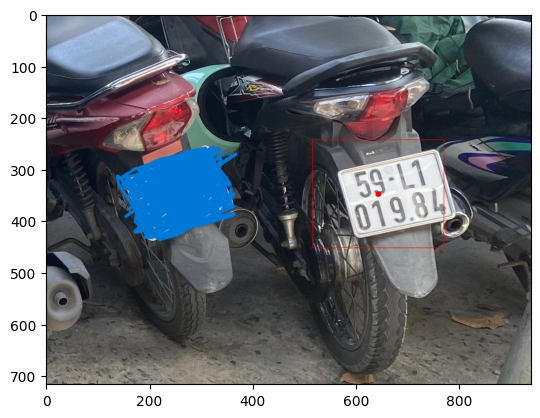

In [69]:
import cv2
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
image = cv2.imread("D:\\Number Plate Region\\Demo\\Image\\img_275.jpg")
# image = cv2.imread("D:\\Number Plate Region\\Mydata\\ValImage\\0054_06642_b.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

resized_image = cv2.resize(image, (416, 416), interpolation = cv2.INTER_AREA)
image_pil = resized_image
resized_image = resized_image.astype(float) 
resized_image /= 255

img = np.expand_dims(resized_image, axis=0)
prediction = yolo.model.predict(img)

xywhcp = decode(*[prediction[0][0],prediction[1][0],prediction[2][0]] , class_num=num_classes, threshold=0.5, version=2)
# print(xywhcp)
if len(xywhcp) > 0:
    xywhcp = soft_nms(xywhcp, num_classes, 0.5)

print(xywhcp)
idx = len(xywhcp) -1 

img_draw = Image.fromarray(image)
draw = ImageDraw.Draw(img_draw)
for i in range(len(xywhcp)):
    x = int(xywhcp[0][0] * image.shape[1])
    y = int(xywhcp[0][1] * image.shape[0])
    w = int(xywhcp[0][2] * image.shape[1]*1.4)
    h = int(xywhcp[0][3] * image.shape[0]*1.1)
    class_i = int(xywhcp[0][5])

    # Vẽ hình tròn
    radius = 5
    draw.ellipse((x - radius, y - radius, x + radius, y + radius), fill='red')

    # Vẽ hình chữ nhật
    x_min, y_min = int(x - w / 2), int(y - h / 2)
    x_max, y_max = int(x + w / 2), int(y + h / 2)
    draw.rectangle([x_min, y_min, x_max, y_max], outline='red')

plt.imshow(img_draw)
plt.show()